# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap import DAPcython
from dap.dap_simulator import DAPSimulator

### General Settings Pick

In [2]:
n_samples = 100
n_summary = 13
dt = 0.01

### Get current

In [3]:
I, t, t_on, t_off = syn_current(duration=70, dt=dt, t_on=15, t_off=20, amp=3.1)
params, labels = obs_params_gbar(reduced_model=True)
dap = DAPcython(-75, params*10)

### Set up the model

In [4]:
sim = DAPSimulator(I, dt, -75, dim_param=2)
stats = DAPSummaryStatsMoments(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [5]:
prior_min = np.array([0, 0])
prior_max = np.array([1, 1])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

### generate desired data

In [6]:
U = dap.simulate(dt, t, I)
y_o = {'data': U.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])

### sample one parameter, simulate and get the summary statistics

In [7]:
params = prior_unif.gen(n_samples=1)
x_o = sim.gen_single(params[0])
y_obs = stats.calc([x_o])

### calculate appropiate z scores

In [8]:
sum_stats = zscore(y, axis=1)
obs_zt = zscore(y_obs, axis=1)
print('sum_stats', sum_stats[0])
print('obs_zt', obs_zt[0])

sum_stats [-0.51822999 -0.25958791 -0.49772872 -0.25633041 -0.25806197 -0.25917198
 -0.25924753 -0.25916224  3.44738386 -0.25413316 -0.2430683  -0.21516209
 -0.16749957]
obs_zt [-0.55228353 -0.35887531 -0.55080176 -0.3324606  -0.41671084 -0.41841975
 -0.41309859 -0.41439989  2.23216135 -0.41260129 -0.4060115  -0.40225739
  2.44575911]


### distance of the z-scored summary statistics 'sum_stats' to the z-scored observed data 'obs_zt'

In [9]:
dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)
dist_argsort = np.argsort(dist_sum_stats)

## Repeat for 1000 in a loop

In [10]:
n_samples = 1000
eps = 1

In [11]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [12]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)     


100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


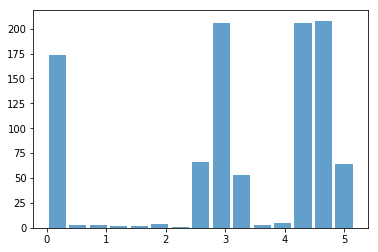

In [23]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [14]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [15]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [16]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

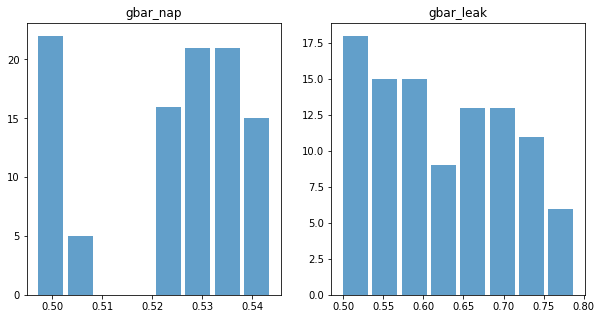

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

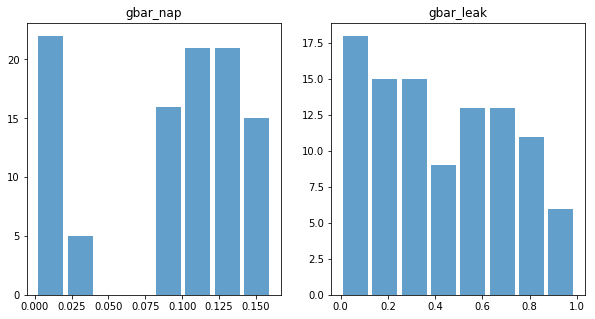

In [27]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

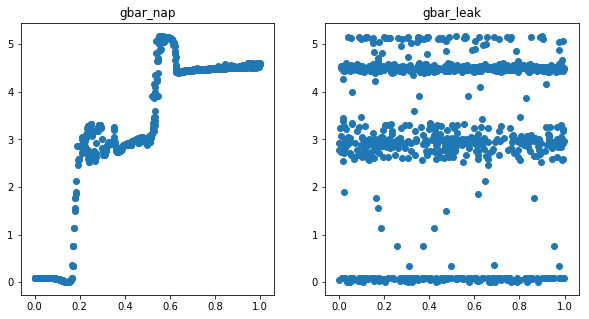

In [48]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(params.transpose()[0], scores)
ax[1].scatter(params.transpose()[1], scores)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);


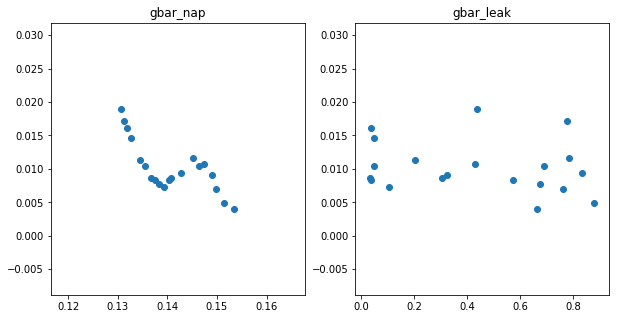

In [50]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(p.transpose()[0], s)
ax[1].scatter(p.transpose()[1], s)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

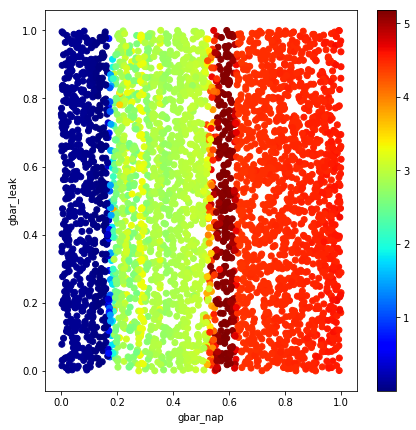

In [114]:
S = np.array([scores]).transpose()
data = np.append(params, S, axis=1)

plt.subplots(1,1,figsize=(7,7))
plt.set_cmap('jet')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

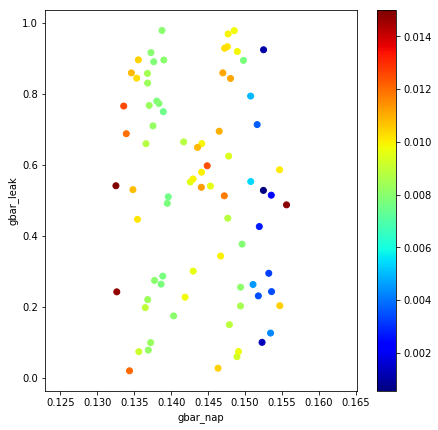

In [115]:
d = np.append(p,  np.array([s]).transpose(), axis=1)

plt.subplots(1,1,figsize=(7,7))
plt.set_cmap('jet')
plt.scatter(d[:,0],d[:,1], c=d[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

In [ ]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);

## Repeat for 4000 in a loop

In [101]:
n_samples = 4000
eps = 1

In [102]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [103]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)     


100%|██████████| 4000/4000 [18:28<00:00,  3.61it/s]


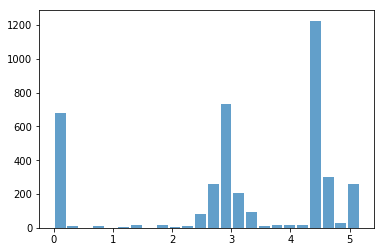

In [104]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [105]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [106]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [107]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

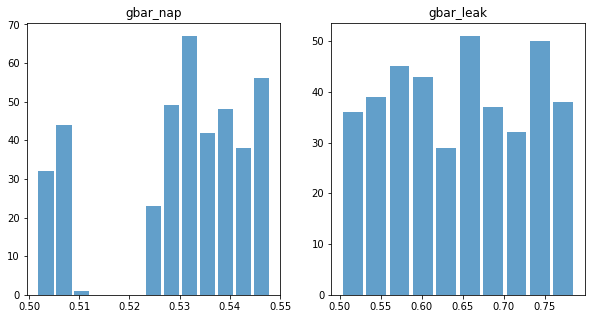

In [108]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

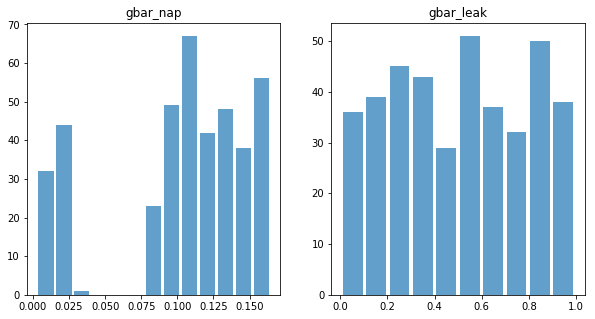

In [109]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax[1].hist(x=params_accept[:,1], bins='auto', alpha=0.7, rwidth=0.85);
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

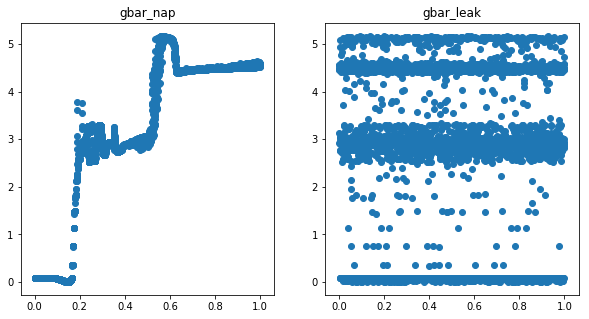

In [110]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(params.transpose()[0], scores)
ax[1].scatter(params.transpose()[1], scores)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);


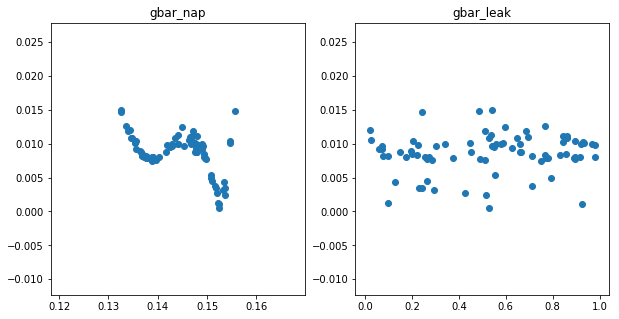

In [111]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(p.transpose()[0], s)
ax[1].scatter(p.transpose()[1], s)

ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

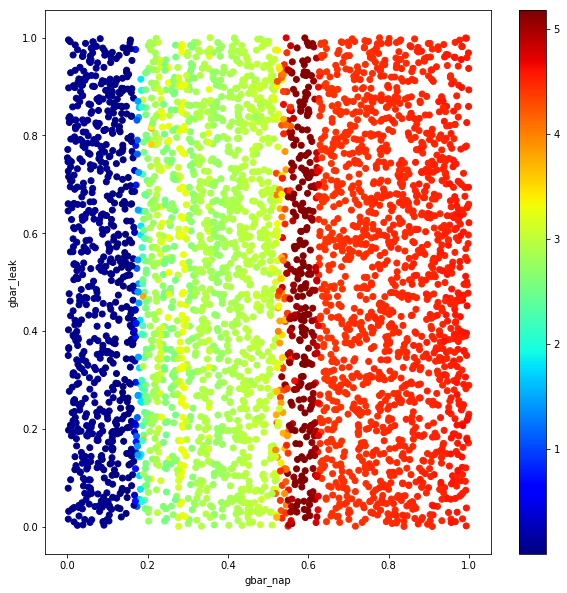

In [112]:
S = np.array([scores]).transpose()
data = np.append(params, S, axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

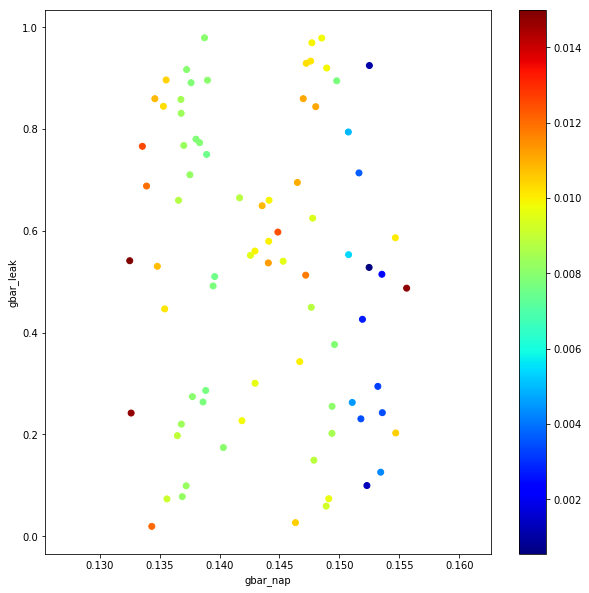

In [113]:
d = np.append(p,  np.array([s]).transpose(), axis=1)

plt.subplots(1,1,figsize=(10,10))
plt.set_cmap('jet')
plt.scatter(d[:,0],d[:,1], c=d[:,2])
plt.colorbar();

plt.xlabel(labels[0])
plt.ylabel(labels[1]);

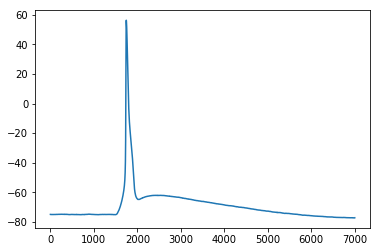

In [116]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
plt.plot(U);